# Inter-subject correlation of representational geometry

For each searchlight (20 mm radius), we correlate the vectorized representational dissimilarity matrix (RDM) of one participant with the average of others', which we refer to as RSA-ISC.
Higer correlations indicate higher quality of the RDMs (i.e., less noise).

## Preparations

### Import Python packages

In [1]:
import os
import numpy as np
import neuroboros as nb
from scipy.stats import ttest_rel
from scipy.optimize import minimize
from functools import partial

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

### Other settings

In [2]:
dsets = ['raiders', 'budapest']
ico = 32
spaces = [f'{a}-ico{b}' for a in ['fsavg', 'fslr', 'onavg'] for b in [ico]]
train_dur, test_dur = '1st-half', '2nd-half'
radius = 20
align_radius = 20
metric = 'correlation'
colors = np.array(sns.color_palette('tab10'))
np.set_printoptions(4, linewidth=200)
if os.path.exists('Arial.ttf'):
    from matplotlib import font_manager
    font_manager.fontManager.addfont('Arial.ttf')
mpl.rcParams['font.family'] = 'Arial'

### Load results

In [3]:
summary_fn = f'sl_rsa/summary_ico{ico}.pkl'  # cache file to avoid excessive I/O
if not os.path.exists(summary_fn):
    results = {}
    for align in ['surf', 'procr', 'ridge']:
        for dset_name in dsets:
            for space in spaces:
                center_space = space.split('-')[0] + '-ico32'
                res = []
                for lr in 'lr':
                    sls = nb.sls(lr, radius, space=space, center_space=center_space)
                    folder = f'sl_rsa_isc/{dset_name}/{space}_{align}_'\
                        f'{align_radius}_{test_dur}/{lr}h_{radius}mm_{metric}'
                    for sl_idx in range(len(sls)):
                        npz = np.load(f'{folder}/{sl_idx:05d}.npz')
                        r = np.stack([npz['r'], npz['ceilings'][2]], axis=0)
                        res.append(r)
                results[dset_name, space, align] = np.stack(res)
    nb.save(summary_fn, results)
results = nb.load(summary_fn)

In [4]:
for res in results.values():
    print(res.shape)  # (number of vertices, r and alpha, number of participants)
    break

(19025, 2, 23)


## Comparison of mean RSA-ISC across template spaces

We used two datasets (_Budapest_ and _Raiders_) and three alignment methods (surface alignment, Procrustes hyperalignment, warp hyperalignment).
Regardless of the dataset and the alignment method, RSA-ISC based on the `onavg` template is always higher than based on other templates.

In [5]:
for align in ['surf', 'procr', 'ridge']:
    for dset_name in dsets:
        ys = np.array([
            results[dset_name, space, align][:, 0, :].mean(axis=0)
            for space in spaces])
        assert np.all(ys[0] < ys[2])
        assert np.all(ys[1] < ys[2])

The figure below shows the average RSA-ISC across subjects (bars) and those of individual participants (gray lines).
For all participants, RSA-ISC based on `onavg` is higher than based on other templates.

1.0 1.0 5.352609886654428e-13


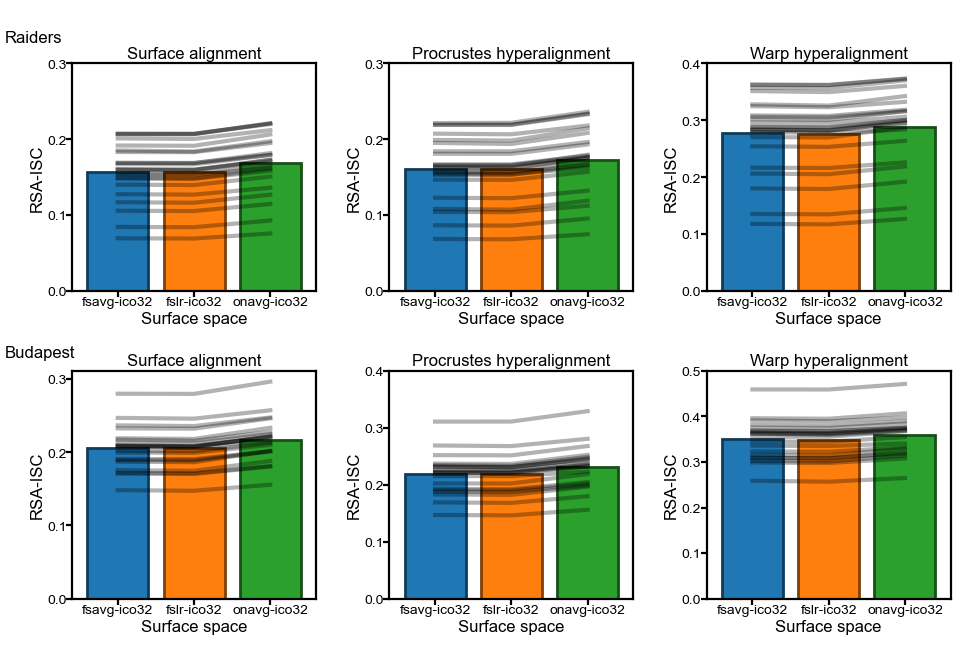

In [6]:
fig, axs = plt.subplots(2, 3, figsize=[_/2.54 for _ in (12, 8)], dpi=200)
pct1, pct2, pp = [], [], []
for ii, dset_name in enumerate(dsets):
    for jj, align in enumerate(['surf', 'procr', 'ridge']):
        ax = axs[ii, jj]
        ys = []
        for i, space in enumerate(spaces):
            a = results[dset_name, space, align][:, 0, :].mean(axis=0)
            m = a.mean(axis=0)
            c = colors[i]
            ax.bar(i, m, facecolor=c, edgecolor=c*0.5, ecolor=c*0.5)
            ys.append(a)
        ax.set_xticks(np.arange(3), labels=spaces)

        ys = np.array(ys)
        for y in ys.T:
            ax.plot(np.arange(3), y, 'k-', alpha=0.3, markersize=1)
        t, p = ttest_rel(ys[2], ys[0])
        pp.append(p)
        assert p < 0.005
        t, p = ttest_rel(ys[2], ys[1])
        pp.append(p)
        assert p < 0.005
        pct1.append(np.mean(ys[0] < ys[2]))
        pct2.append(np.mean(ys[1] < ys[2]))

        max_ = int(np.ceil(ys.max() * 10))
        yy = np.round(np.arange(max_ + 1) * 0.1, 3)
        ax.set_yticks(yy, labels=[f'{_}' for _ in yy])
        ax.set_xlim([-0.6, 2.6])
        ax.tick_params(axis='both', pad=0, length=2, labelsize=5)
        ax.set_ylabel('RSA-ISC', size=6, labelpad=1)
        ax.set_xlabel('Surface space', size=6, labelpad=1)
        title = {'procr': 'Procrustes hyperalignment',
                 'ridge': 'Warp hyperalignment',
                 'surf': 'Surface alignment',
                }[align]
        ax.set_title(f'{title}', size=6, pad=2)
    ax.annotate(dset_name.capitalize(), (0.005, 0.99 - ii * 0.5),
                xycoords='figure fraction', size=6, va='top')

print(np.mean(pct1), np.mean(pct2), np.max(pp))
fig.subplots_adjust(left=0.06, right=0.99, top=0.92, bottom=0.07,
                    wspace=0.3, hspace=0.35)
plt.savefig('sl_rsa_bar.png', dpi=300, transparent=True)
plt.show()

## Difference between `onavg` and other template spaces

This figure emphasizes the difference in RSA-ISC between `onavg` and other template spaces.

Note that RSA-ISC varies substantially across participants.
For individual participants, the difference scores between `onavg` and other templates are not affected by these individual differences.
The standard error of the difference score is much smaller than the mean difference, for both datasets and all alignment methods.

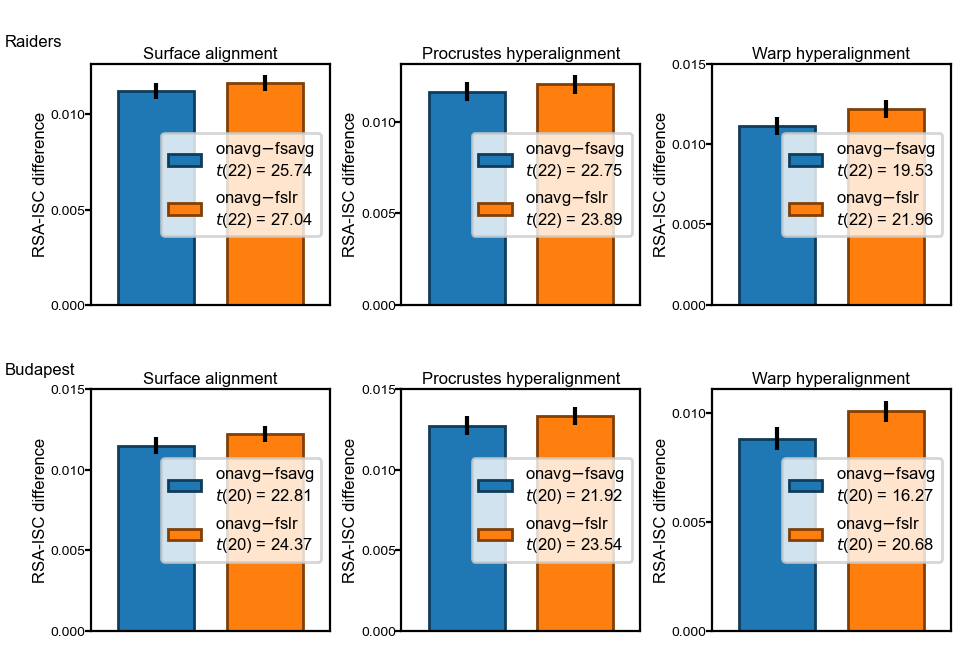

In [7]:
fig, axs = plt.subplots(
    2, 3, figsize=[_/2.54 for _ in [12, 8]], dpi=200)

for ii, dset_name in enumerate(dsets):
    for jj, align in enumerate(['surf', 'procr', 'ridge']):
        ax = axs[ii, jj]
        ys = [results[dset_name, space, align][:, 0, :].mean(axis=0)
              for space in spaces]
        ys = [ys[-1] - _ for _ in ys[:-1]]

        max_ = []
        onavg = results[dset_name, spaces[-1], align][:, 0, :].mean(axis=0)
        for kk, space in enumerate(spaces[:-1]):
            y = results[dset_name, space, align][:, 0, :].mean(axis=0)
            diff = onavg - y
            m = diff.mean(axis=0)
            se = diff.std(axis=0, ddof=1) / np.sqrt(diff.shape[0])
            c = colors[kk]
            t, p = ttest_rel(onavg, y)
            dof = len(onavg) - 1
            label = f'{spaces[-1].split("-")[0]}$ - ${spaces[kk].split("-")[0]}'\
                    f'\n$t$({dof}) = {t:.2f}'
            ax.bar(kk, m, yerr=se, color=c, ec=c*0.5, width=0.7, label=label)
            max_.append(m + se)
            assert p < 1e-6
        max_ = int(np.ceil(np.max(max_) * 1.1 * 1000))

        ax.set_xticks([])
        ax.set_xlim(np.array([-0.6, 1.6]))
        yy = np.arange(0, max_ + 1, 5)
        ax.set_yticks(yy  * 0.001)
        ax.tick_params(axis='both', pad=0, length=2, labelsize=5)
        ax.set_ylabel('RSA-ISC difference', size=6, labelpad=1)
        ax.set_xlim(np.array([-0.6, 1.6]))

        title = {'procr': 'Procrustes hyperalignment',
                 'ridge': 'Warp hyperalignment',
                 'surf': 'Surface alignment',
                }[align]
        ax.set_title(f'{title}', size=6, pad=2)
        ax.legend(fontsize=6, fancybox=True, loc='center right')
    ax.annotate(dset_name.capitalize(), (0.005, 0.99 - ii * 0.52),
                xycoords='figure fraction', size=6, va='top')

fig.subplots_adjust(
    left=0.08, right=0.99, top=0.92, bottom=0.02, wspace=0.3, hspace=0.35)
plt.savefig('sl_rsa_diff.png', dpi=300)
plt.show()

## RSA-ISC with less data

These two functions based on the Spearman-Brown prediction formular can be used to estimate how the reliability changes with the amount of data, and eventually, how the amount of data affects the correlation coefficient (RSA-ISC).

In [8]:
def predict_correlation_part1(res):
    """
    Correct for attenuation of correlation based on the reliability of the
    predicted RDM (averaged across the other n - 1 participants).

    Notes
    -----
    Spearman, C. (1904). The proof and measurement of association between two
    things. American Journal of Psychology, 15, 72–101.
    """
    r, alpha = res[:, 0, :], res[:, 1, :]
    r0 = r / np.sqrt(alpha)
    n0 = res.shape[-1] - 1
    return r0, n0, alpha

def predict_correlation_part2(n, n0, r0, alpha):
    """
    Estimate the attenuation based on smaller number of participants and the
    correlation accordingly.
    """
    alpha_new = nb.stats.spearman_brown(alpha, n / n0)
    r_new = r0 * np.sqrt(alpha_new)
    return r_new

RSA-ISC systematically increases with more data, because the average RDM across a larger number of participants tends to have less noise in it, and therefore the correlation is less attenuated by noise.

Across different amounts of data, different datasets, and different alignment methods, RSA-ISC based on `onavg` is consistently higher than those based on other templates.

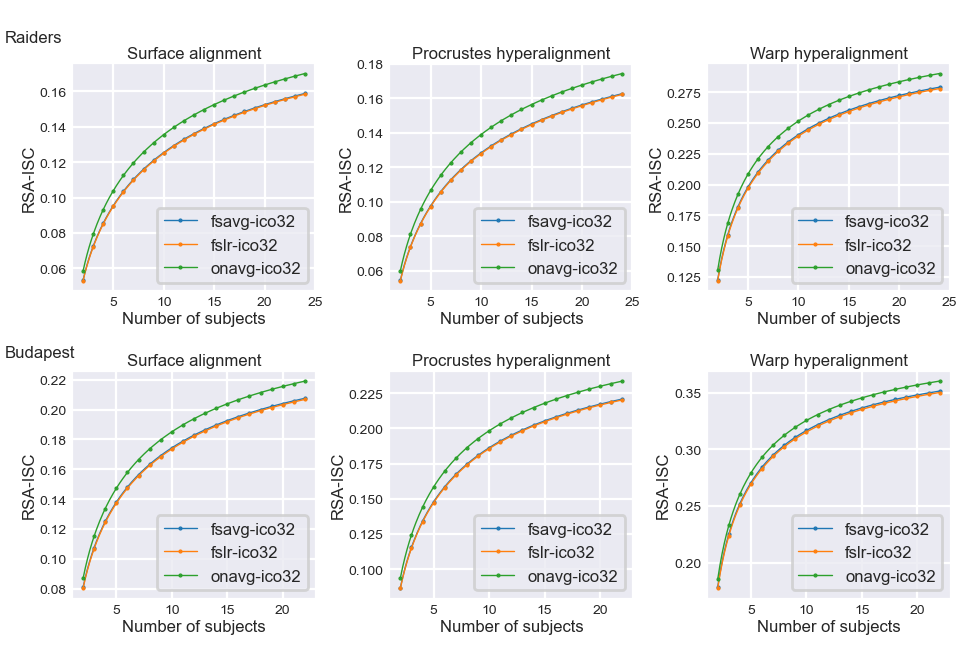

In [9]:
with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots(
        2, 3, figsize=[_/2.54 for _ in [12, 8]], dpi=200)

    for ii, dset_name in enumerate(dsets):
        for jj, align in enumerate(['surf', 'procr', 'ridge']):
            ax = axs[ii, jj]
            for kk, space in enumerate(spaces):
                res = results[dset_name, space, align]
                r0, n0, alpha = predict_correlation_part1(res)
                xs = np.arange(n0 * 10 + 1) * 0.1 + 1
                ys = []
                for x in xs:
                    y = predict_correlation_part2(x, n0, r0, alpha)
                    ys.append(y.mean())
                ys = np.array(ys)
                ax.plot(xs+1, ys, '.-', markersize=1, linewidth=0.5,
                        markevery=10, color=colors[kk], label=space)

            ax.tick_params(axis='both', pad=0, length=2, labelsize=5)
            ax.set_ylabel('RSA-ISC', size=6, labelpad=1)
            ax.set_xlabel('Number of subjects', size=6, labelpad=1)
            title = {'procr': 'Procrustes hyperalignment',
                     'ridge': 'Warp hyperalignment',
                     'surf': 'Surface alignment',
                    }[align]
            ax.set_title(f'{title}', size=6, pad=2)
            ax.legend(fontsize=6, fancybox=True)
        ax.annotate(dset_name.capitalize(), (0.005, 0.99 - ii * 0.5),
                    xycoords='figure fraction', size=6, va='top')

    fig.subplots_adjust(
        left=0.06, right=0.99, top=0.92, bottom=0.07, wspace=0.3, hspace=0.35)
    plt.savefig('sl_rsa_line.png', dpi=300)
    plt.show()

## The amount of data required for the same performance

Here we use the Spearman-Brown prediction formular and `scipy.optimize.minimize` to compute the amount of data required for `onavg` to achieve the same RSA-ISC as other templates.

In [10]:
def loss_func(n, r0, alpha, n0, target):
    alpha_new = nb.stats.spearman_brown(alpha, n / n0)
    r_new = r0 * np.sqrt(alpha_new)
    return np.abs(r_new.mean() - target)

Compared to other template spaces, `onavg` only needs about 3/4 of the amount of data to achieve the same RSA-ISC.
In other words, data usage based on the `onavg` template is approximately 1.3--1.4 times more efficient.

In [11]:
for align in ['surf', 'procr', 'ridge']:
    for dset_name in dsets:
        res = results[dset_name, spaces[-1], align]
        r0, n0, alpha = predict_correlation_part1(res)
        for space in spaces:
            res = results[dset_name, space, align]
            r = res[:, 0, :].mean()
            opt_res = minimize(loss_func, n0, (r0, alpha, n0, r), bounds=[(0, n0)])
            pred = predict_correlation_part2(opt_res.x, n0, r0, alpha).mean()
            np.testing.assert_allclose(pred, r)
            ratio = (opt_res.x[0] + 1) / (n0 + 1)
            print(f'{dset_name:8s}, {align:5s}, {space:11s}, {r:.5f}, '
                  f'{opt_res.x[0] + 1:.2f}, {ratio:.4f}, {1/ratio:.4f}')

raiders , surf , fsavg-ico32, 0.15723, 16.96, 0.7374, 1.3561
raiders , surf , fslr-ico32 , 0.15683, 16.78, 0.7297, 1.3703
raiders , surf , onavg-ico32, 0.16845, 23.00, 1.0000, 1.0000
budapest, surf , fsavg-ico32, 0.20588, 15.72, 0.7487, 1.3357
budapest, surf , fslr-ico32 , 0.20514, 15.45, 0.7357, 1.3592
budapest, surf , onavg-ico32, 0.21738, 21.00, 1.0000, 1.0000
raiders , procr, fsavg-ico32, 0.16119, 16.90, 0.7348, 1.3609
raiders , procr, fslr-ico32 , 0.16079, 16.73, 0.7274, 1.3747
raiders , procr, onavg-ico32, 0.17285, 23.00, 1.0000, 1.0000
budapest, procr, fsavg-ico32, 0.21907, 15.42, 0.7341, 1.3621
budapest, procr, fslr-ico32 , 0.21847, 15.21, 0.7242, 1.3807
budapest, procr, onavg-ico32, 0.23180, 21.00, 1.0000, 1.0000
raiders , ridge, fsavg-ico32, 0.27757, 17.24, 0.7498, 1.3338
raiders , ridge, fslr-ico32 , 0.27650, 16.81, 0.7309, 1.3682
raiders , ridge, onavg-ico32, 0.28870, 23.00, 1.0000, 1.0000
budapest, ridge, fsavg-ico32, 0.34993, 16.63, 0.7920, 1.2626
budapest, ridge, fslr-ic